In [23]:
import requests
from bs4 import BeautifulSoup as bs
import re
import json
import pandas as pd
import numpy as np
import yfinance as yf
from dateutil import parser
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.forecasting.arima import AutoARIMA
sns.set(font_scale=1.1, rc={
    'figure.figsize': (15, 10),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#333333',
    'xtick.color': '#666666',
    'ytick.color': '#666666'
})
from tslearn.svm import TimeSeriesSVR
from sklearn.metrics import r2_score

In [24]:
def get_SP500_symbols():
    payload = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    first_table = payload[0]
    second_table = payload[1]

    SandP_info = first_table
    SandP_info.head()
    symbols = SandP_info['Symbol'].values.tolist()
    symbols = [symbol.replace('.','-') for symbol in symbols]
    return symbols

In [25]:
def get_url(url):
    response = requests.get(url)
    return response.url

In [26]:
def get_pricing(symbols):
    all_pricing = yf.download(symbols)
    return all_pricing

In [27]:
def get_table_from_url(url):
    r = requests.get(url)
    p = re.compile(r' var originalData = (.*?);\r\n\r\n\r',re.DOTALL)
    data = json.loads(p.findall(r.text)[0])
    headers = list(data[0].keys())
    headers.remove('popup_icon')
    result = []

    for row in data:
        soup = bs(row['field_name'])
        field_name = soup.select_one('a, span').text
        fields = list(row.values())[2:]
        fields.insert(0, field_name)
        result.append(fields)

    pd.option_context('display.max_rows', None, 'display.max_columns', None)
    df = pd.DataFrame(result, columns = headers)
    df.set_index('field_name',inplace=True)
    df.index.rename('Quarterly Data',inplace=True)
    return df

In [28]:
def get_table(symbol):
    ticker = symbol.replace('-','.')
    url = f'https://www.macrotrends.net/stocks/charts/{ticker}'
    response = get_url(url)
    response.split('/')[-3:-1]
    part1= response.split('/')[-3]
    part2 = response.split('/')[-2]
    url = f'https://www.macrotrends.net/stocks/charts/{part1}/{part2}/income-statement?freq=Q'
    df = get_table_from_url(url)
    df = df.transpose()
    # df.index = pd.PeriodIndex(df.index,freq='Q')
    df.index = pd.to_datetime(df.index)
    return df

In [29]:
aapl = yf.Ticker("AAPL")
hist = aapl.history(period="max")

In [30]:
dates = hist.loc[hist['Stock Splits'] != 0].index

In [31]:
splits = hist.loc[hist['Stock Splits'] != 0]['Stock Splits'].values

[*********************100%***********************]  1 of 1 completed


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:5233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


Real Close is 125.330% of Predicted Close

100% is fair value.
> 100% means overvalued, < 100% means undervalued.


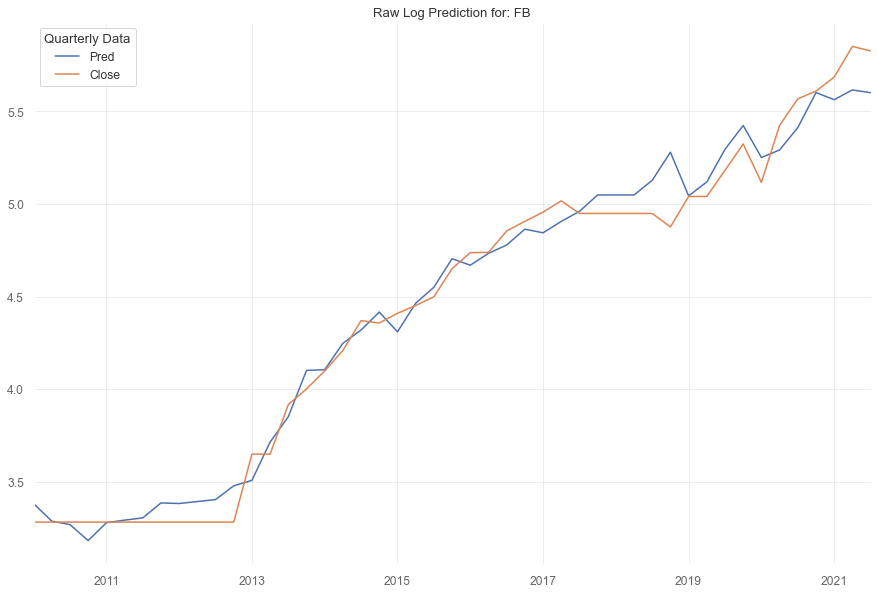

In [46]:
stock = str(input())
price = get_pricing(stock)
form = get_table(stock)

res = []
for i in form.index:
    try:
        j = price.index.get_loc(i)
        res.append(price.iloc[j]['Close'])
    except:
        res.append(np.nan)
form['Close'] = res
form['Close'] = pd.concat([form['Close'].ffill(), form['Close'].bfill()]).groupby(level=0).mean()
for i in form:
    form[i] = pd.to_numeric(form[i])

form = form.apply(np.log)
form = form.dropna(axis=1,how='all')
form = form.dropna(axis=0,how='all')
form = form.iloc[::-1]
form.index = pd.PeriodIndex(form.index,freq='Q')

form = form.dropna(axis=0,how='all',thresh=len(form.columns)/2)
form = form.dropna(axis=1,how='all',thresh=len(form)/2)
form = form.fillna(form.mean())

reg = TimeSeriesSVR(kernel="gak", gamma="auto")

y = form['Close']
X = form.loc[:,form.columns != 'Close']
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.mean())
y_pred = reg.fit(X, y).predict(X)

new_df = form
new_df['Pred'] = y_pred
new_df['Pred Yearly Rolling'] = new_df['Pred'].rolling(4).mean()
new_df['Value'] = new_df['Close']/new_df['Pred Yearly Rolling']
new_df[['Close','Pred','Pred Yearly Rolling','Value']].to_csv(f'C:/Users/Matthew/jupyternotes/Stocks/SVR Forecasting/{stock}_forecast.csv')
new_df[['Pred','Close']].plot(title=f'Raw Log Prediction for: {stock}')


_ = (new_df['Close'].apply(np.exp).iloc[-1] / new_df['Pred'].apply(np.exp).iloc[-1])*100
print(f'Real Close is {_:.3f}% of Predicted Close')
print('')
print('100% is fair value.')
print('> 100% means overvalued, < 100% means undervalued.')

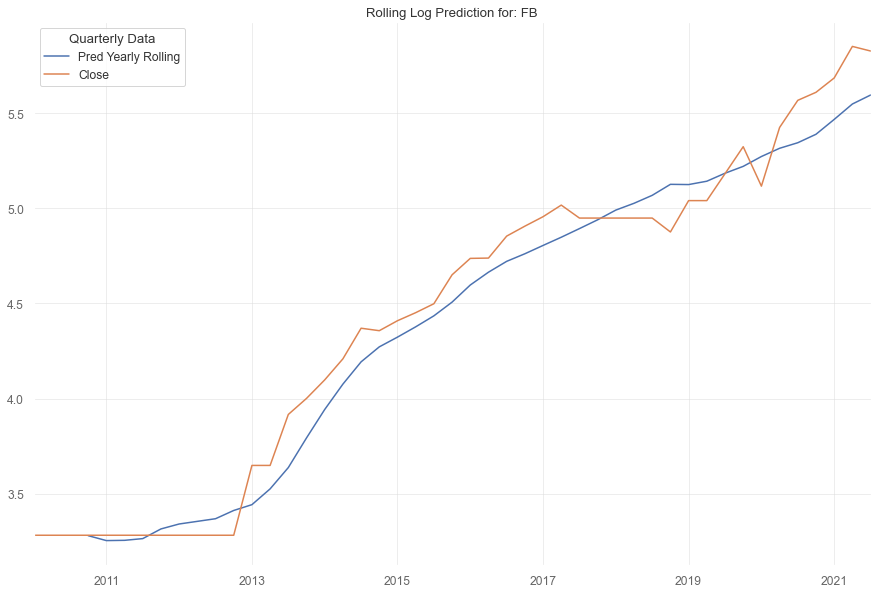

In [47]:
fig = new_df[['Pred Yearly Rolling','Close']].plot(title=f'Rolling Log Prediction for: {stock}')

In [48]:
r2_score(new_df.dropna()['Close'],new_df.dropna()['Pred Yearly Rolling'])

0.9665993553492775

<AxesSubplot:ylabel='Pred'>

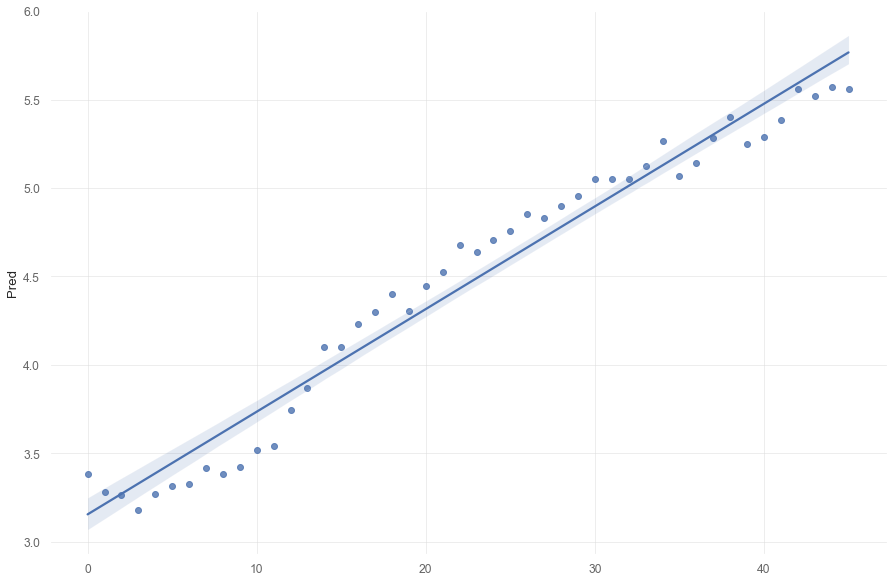

In [35]:
sns.regplot(data=new_df,x=np.arange(len(new_df.index)),y='Pred')

In [67]:
_quarter = new_df.index[-1].quarter
_year = new_df.index[-1].year
l_ = np.exp(new_df['Pred'].iloc[-1])
print(f'For Q{_quarter} of {_year}')
print('-'*100)
print(f'Regression Price : {l_:.2f}')
_ = new_df['Close'].apply(np.exp).iloc[-1]
print(f'Real Price: {_:.2f}')
print('-'*50)
print(f'Real Close is {_/l_*100:.3f}% of Predicted Close')
print('-'*50)
print('100% is fair value.')
print('> 100% means overvalued, < 100% means undervalued.')

For Q3 of 2021
----------------------------------------------------------------------------------------------------
Regression Price : 270.80
Real Price: 339.39
--------------------------------------------------
Real Close is 125.330% of Predicted Close
--------------------------------------------------
100% is fair value.
> 100% means overvalued, < 100% means undervalued.


<AxesSubplot:>

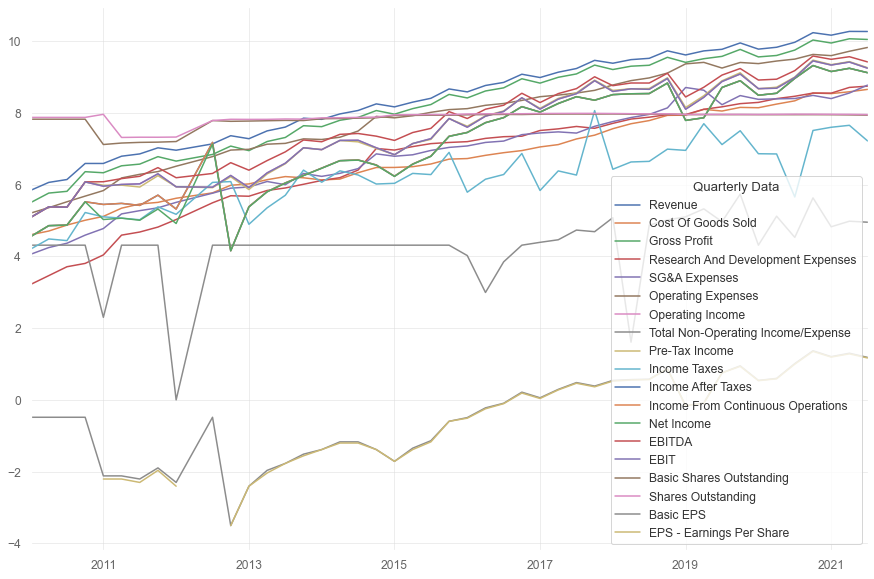

In [37]:
X.plot()

In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [39]:
data_gen = TimeseriesGenerator(X, y, length=10)

In [40]:
batch_0 = data_gen[0]
train_X, train_y = batch_0

In [41]:
train_X.shape

(36, 10, 19)

In [42]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 64)            21504     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 33,953
Trainable params: 33,953
Non-trainable params: 0
_________________________________________________________________


In [43]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(train_X, train_y, epochs=50, batch_size=8, validation_split=0.1, verbose=1)

Epoch 1/50
4/4 [==============================] - 2s 165ms/step - loss: nan - val_loss: nan
Epoch 2/50
4/4 [==============================] - 0s 11ms/step - loss: nan - val_loss: nan
Epoch 3/50
4/4 [==============================] - 0s 11ms/step - loss: nan - val_loss: nan
Epoch 4/50
4/4 [==============================] - 0s 11ms/step - loss: nan - val_loss: nan
Epoch 5/50
4/4 [==============================] - 0s 13ms/step - loss: nan - val_loss: nan
Epoch 6/50
4/4 [==============================] - 0s 14ms/step - loss: nan - val_loss: nan
Epoch 7/50
4/4 [==============================] - 0s 11ms/step - loss: nan - val_loss: nan
Epoch 8/50
4/4 [==============================] - 0s 11ms/step - loss: nan - val_loss: nan
Epoch 9/50
4/4 [==============================] - 0s 13ms/step - loss: nan - val_loss: nan
Epoch 10/50
4/4 [==============================] - 0s 11ms/step - loss: nan - val_loss: nan
Epoch 11/50
4/4 [==============================] - 0s 11ms/step - loss: nan - val_loss: 

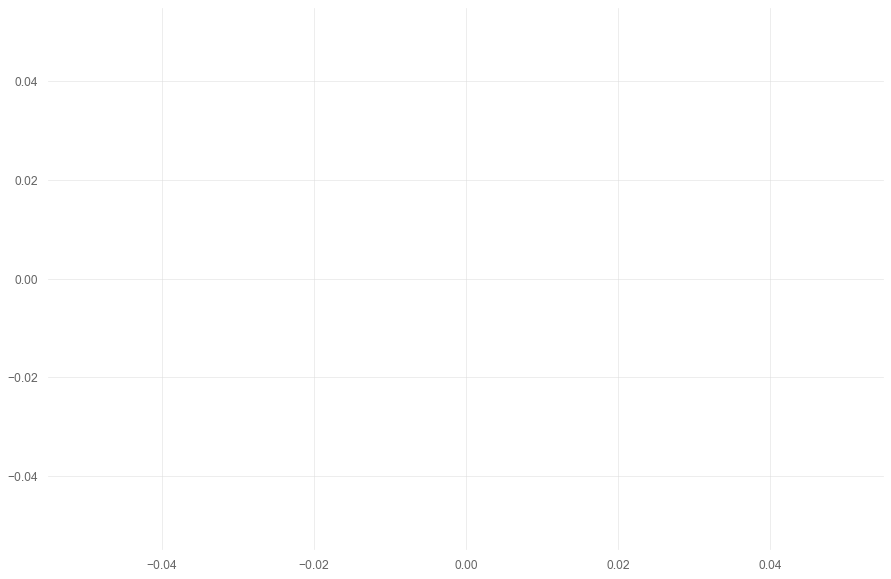

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

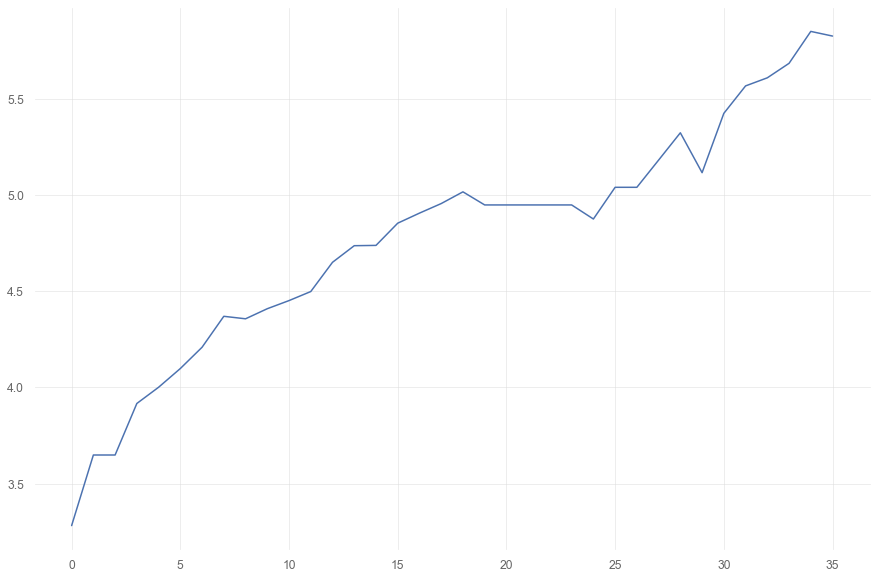

In [45]:
plt.plot(model.predict(train_X), color='red')
plt.plot(train_y)